In [1]:
import torch
from torchvision import datasets,transforms
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
train=datasets.OxfordIIITPet('./train', download=True, target_types='segmentation', split='trainval')

100%|██████████| 791918971/791918971 [00:55<00:00, 14145515.20it/s]


Extracting train/oxford-iiit-pet/images.tar.gz to train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 6818552.73it/s] 


Extracting train/oxford-iiit-pet/annotations.tar.gz to train/oxford-iiit-pet


In [3]:
df = pd.read_csv(
    "./train/oxford-iiit-pet/annotations/list.txt",
    delimiter=" ",
    skiprows=6,
    header=None,
    names=["stem", "class_id", "species", "breed"]
)
df["class_name"] = df.stem.map(lambda x: x.split("_")[0])
df["image"] = df.stem.map(lambda x: f"./train/oxford-iiit-pet/images/{x}.jpg")
df["trimap"] = df.stem.map(lambda x: f"./train/oxford-iiit-pet/annotations/trimaps/{x}.png")

In [4]:
class IIITDataset(Dataset):
  def __init__(self, df, tfm=None):
    self.df = df
    self.tfm = tfm
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, i):
    img = Image.open(self.df.image.iloc[i]).convert('RGB')
    mask = Image.open(self.df.trimap.iloc[i])
    img = np.asarray(img)
    mask = np.asarray(mask)
    if self.tfm:
        augmented = self.tfm(image=img, mask=mask)
        img, mask = augmented["image"], augmented["mask"]
    return img, mask


In [5]:
train_tfm = A.Compose([
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
    A.SmallestMaxSize(224),
    A.RandomCrop(224, 224),
    A.Normalize(),
    ToTensorV2(),
])
val_tfm = A.Compose([
    A.SmallestMaxSize(224),
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2(),

])

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

def imagenet_denorm(x):
    """x: array-like with shape (..., H, W, C)"""
    return x * imagenet_std + imagenet_mean

skf = StratifiedKFold(5)
train_idx, val_idx = next(iter(skf.split(df, df.class_id)))
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_ds = IIITDataset(train_df, tfm=train_tfm)
val_ds = IIITDataset(val_df, tfm=val_tfm)

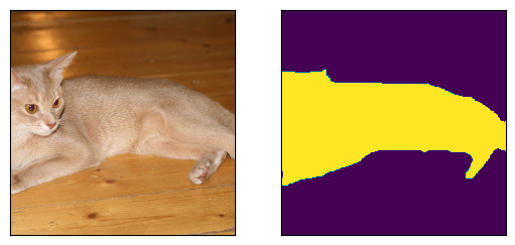

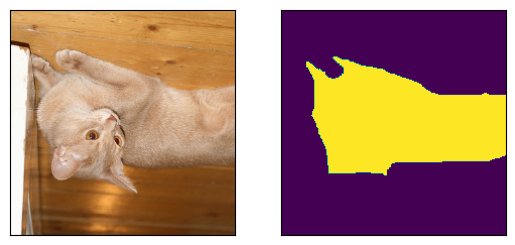

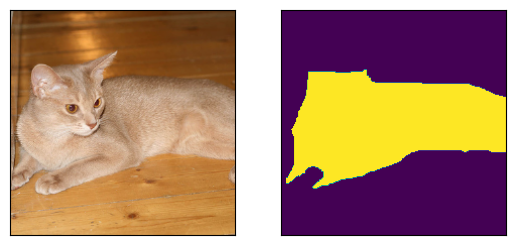

In [6]:
MASK_FG = 1
MASK_BG = 2
MASK_IGNORE = 3
for _ in range(3):
    img, mask = train_ds[1]
    plt.subplot(1,2,1)
    plt.imshow(imagenet_denorm(img.numpy().transpose(1,2,0)))
    plt.xticks([]); plt.yticks([])
    plt.subplot(1,2,2)
    plt.imshow(mask == MASK_FG)
    plt.xticks([]); plt.yticks([])
    plt.show()

In [7]:
SEED =1
cuda = torch.cuda.is_available()
print("CUDA Available", cuda)
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=8, num_workers=1, pin_memory=True)  if cuda else dict(shuffle=True, batch_size=8)

train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)
test_loader = torch.utils.data.DataLoader(val_ds, **dataloader_args)

CUDA Available True


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, do_maxpool):
        super(ContractingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.do_maxpool = do_maxpool
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        skip = x  # store the output for the skip connection
        if self.do_maxpool:
          x = self.maxpool(x)
        
        return x, skip

class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        
    def forward(self, x, skip):

        x = self.upsample(x)
        # concatenate the skip connection
        x = torch.cat((x, skip), dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.contract1 = ContractingBlock(in_channels, 64, True)
        self.contract2 = ContractingBlock(64, 128, True)
        self.contract3 = ContractingBlock(128, 256, True)
        self.contract4 = ContractingBlock(256, 512, False)
        
        self.expand1 = ExpandingBlock(512, 256)
        self.expand2 = ExpandingBlock(256, 128)
        self.expand3 = ExpandingBlock(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Contracting path
        x, skip1 = self.contract1(x)
        x, skip2 = self.contract2(x)
        x, skip3 = self.contract3(x)
        x, _ = self.contract4(x)
        
        # Expanding path
        x = self.expand1(x, skip3)
        x = self.expand2(x, skip2)
        x = self.expand3(x, skip1)
        x = self.final_conv(x)
        return x

In [9]:
! pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = UNet(3,3).to(device)
summary(model, input_size=(3,224,224))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
  ContractingBlock-8  [[-1, 64, 112, 112], [-1, 64, 224, 224]]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112] 

In [10]:
crit = nn.BCEWithLogitsLoss(reduction='none')

In [11]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data,target = data.to(device), target.to(device)
    fg = (target.detach() == MASK_FG).float()
    valid_mask = (target.detach() != MASK_IGNORE)
    y = model(data).squeeze()
    loss = torch.masked_select(crit(y, fg), valid_mask).mean()
    pbar.set_description(desc=f'Loss={loss.item()} Batch_id = {batch_idx}')

def test(model, device , test_loader):
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for data, target in test_loader:
        x, t = data.to(device), target.to(device)
        fg = (t.detach() == MASK_FG).float()
        valid_mask = (t.detach() != MASK_IGNORE)
        x = x.to(device)
        y = model(x).squeeze()
        loss = torch.masked_select(crit(y, fg), valid_mask).mean()
        test_loss += loss.item()
        #print("loss",loss)
  test_loss /= len(test_loader.dataset)
  print("test_loss",test_loss)
     



In [12]:
model = UNet(3,1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS=15
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

EPOCH: 0


Loss=0.6928905844688416 Batch_id = 734: 100%|██████████| 735/735 [01:31<00:00,  8.00it/s]


test_loss 0.07937750682538869
EPOCH: 1


Loss=0.7469668984413147 Batch_id = 734: 100%|██████████| 735/735 [01:26<00:00,  8.50it/s]


test_loss 0.07955150032530026
EPOCH: 2


Loss=0.8000314831733704 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.59it/s]


test_loss 0.0794353938832575
EPOCH: 3


Loss=0.7136784195899963 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.58it/s]


test_loss 0.07955454551443762
EPOCH: 4


Loss=0.7081242799758911 Batch_id = 734: 100%|██████████| 735/735 [01:26<00:00,  8.52it/s]


test_loss 0.07947077824144948
EPOCH: 5


Loss=0.7243865132331848 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.60it/s]


test_loss 0.07946830651387066
EPOCH: 6


Loss=0.7474773526191711 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.57it/s]


test_loss 0.07942377783003307
EPOCH: 7


Loss=0.6711037158966064 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.55it/s]


test_loss 0.07933973795702669
EPOCH: 8


Loss=0.6475950479507446 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.61it/s]


test_loss 0.07944695625175424
EPOCH: 9


Loss=0.6169878244400024 Batch_id = 734: 100%|██████████| 735/735 [01:26<00:00,  8.52it/s]


test_loss 0.07946255403716548
EPOCH: 10


Loss=0.7279207110404968 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.61it/s]


test_loss 0.07941641576436101
EPOCH: 11


Loss=0.5920630097389221 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.56it/s]


test_loss 0.07937763402251159
EPOCH: 12


Loss=0.640949547290802 Batch_id = 734: 100%|██████████| 735/735 [01:26<00:00,  8.53it/s]


test_loss 0.07943999491581301
EPOCH: 13


Loss=0.7677757143974304 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.57it/s]


test_loss 0.07941644370150404
EPOCH: 14


Loss=0.7545332312583923 Batch_id = 734: 100%|██████████| 735/735 [01:25<00:00,  8.62it/s]


test_loss 0.07943105515168637
